In [1]:
from datamodules import SHMUDataModule
from pathlib import Path
from utils.config import load_config

confpath = Path("") / "configs/LUPIN_finetune"
dsconf = load_config(confpath / "datasets.yaml")
modelconf = load_config(confpath / "model.yaml")

datamodule = SHMUDataModule(dsconf, modelconf.train_params)
datamodule.setup("test")
dataset = datamodule.test_dataset

test_dataloader = datamodule.test_dataloader()

/opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pysteps configuration file found at: /opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/pysteps/pystepsrc



In [3]:
import torch
from models import LUMIN

model = LUMIN(modelconf).load_from_checkpoint("/data/softec-lagrangian-nowcasting/checkpoints/LUMIN-differenced-pretrainedMFUNET-rmse/epoch=4-step=1280.ckpt", config=modelconf, map_location=torch.device('cpu'))

In [38]:
import torch
from models import MFUNET

confpath = Path("") / "configs/MFUNET_rmse"
dsconf = load_config(confpath / "datasets.yaml")
modelconf = load_config(confpath / "model.yaml")

model = MFUNET(modelconf).load_from_checkpoint("/data/softec-lagrangian-nowcasting/checkpoints/mfunet-rmse/epoch=6-step=2065-v1.ckpt", config=modelconf, map_location=torch.device('cuda:0'))

In [39]:
x = dataset[40][0]
x = torch.unsqueeze(torch.squeeze(x), dim=0).float().to(model.device)
# x = torch.log(x + 0.01)
# x[x < 0] = x.min()

y = dataset[40][1]
y = torch.unsqueeze(torch.squeeze(y), dim=0).float().to(model.device)

In [50]:
dataset.get_common_time(40).strftime("%Y%m%d%H%M")

'201809022010'

In [55]:
import _pickle as cPickle
with open(rf"/data/maly_javornik_CMAX_60k_2/motion_fields/201809022010.pkl", "rb") as input_file:
   mf_lk = cPickle.load(input_file)

In [40]:
extra, mf = model(x)

y_i = torch.diff(torch.cat((extra, y[:, None, 0, :, :]), dim=1), dim=1)

pred_np = extra.detach().cpu().numpy()
# mf = mf[0].detach().cpu().numpy()

nowcast, mfcast = model._iterative_prediction((x, y, None), stage='predict')
#nowcast_np = dataset.from_transformed(nowcast).detach().cpu().numpy()
mfcast_np = mfcast.detach().cpu().numpy()

pred_total_np = dataset.from_transformed((extra).detach().cpu()).numpy()

In [7]:
pred, extra, mf = model(x)

y_i = torch.diff(torch.cat((pred, y[:, None, 0, :, :]), dim=1), dim=1)

pred_np = pred.detach().cpu().numpy()
# mf = mf[0].detach().cpu().numpy()
nowcast = model._iterative_prediction((x, y, None), stage='predict')
nowcast, mfcast = model._iterative_prediction((x, y, None), stage='predict')

/opt/anacondas/anaconda3/envs/nowcasting/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [68]:
mfcast[:,3:].shape

import torch
import torch.nn.functional as F

sobel_x = torch.tensor([[-1.,  0.,  1.],
                        [-2.,  0.,  2.],
                        [-1.,  0.,  1.]]).view(1, 1, 3, 3).to(mfcast.device)
sobel_y = torch.tensor([[-1., -2., -1.],
                        [ 0.,  0.,  0.],
                        [ 1.,  2.,  1.]]).view(1, 1, 3, 3).to(mfcast.device)
diff_u = F.conv2d(mfcast[:,3,0:1], sobel_x)
diff_v = F.conv2d(mfcast[:,3,0:1], sobel_y)
torch.sum(torch.abs(diff_u + diff_v)) / (336 * 336)

tensor(0.5735, device='cuda:0', grad_fn=<DivBackward0>)

In [67]:
diff_u.shape

torch.Size([1, 1, 334, 334])

In [41]:
import numpy as np

nowcast_np = dataset.from_transformed(nowcast).detach().cpu().numpy()
nowcast_np_mmh = nowcast.detach().cpu().numpy()
nowcast_np_mmh[nowcast_np_mmh <= 1] = 0
mfcast_np = mfcast.detach().cpu().numpy()
#pred_total_np = dataset.from_transformed((pred + extra).detach().cpu()).numpy()

x_lagrangian = x.clone()

for i in range(x.shape[1]):
    x_lagrangian[:,i] = model._extrapolate(6-i, x_lagrangian[:,[i]], (mf))[:,-1]

x_lagrangian_diff = torch.diff(x_lagrangian, dim=1)
x_np = np.array(dataset.from_transformed(x[0].detach().cpu()))
x_np_mmh = np.array(x[0].detach().cpu())
x_np_mmh[x_np_mmh <= 1] = 0
y_np = np.array(dataset.from_transformed(y[0].detach().cpu()))
x_lagrangian_np = np.array(dataset.from_transformed(x_lagrangian[0].detach().cpu()))
x_lagrangian_np_mmh = x_lagrangian[0].detach().cpu().numpy()
x_lagrangian_np_mmh[x_lagrangian_np_mmh <= 1] = 0
x_lagrangian_diff_np = np.array(x_lagrangian_diff[0].detach().cpu())
y_i_np = y_i.detach().cpu().numpy()

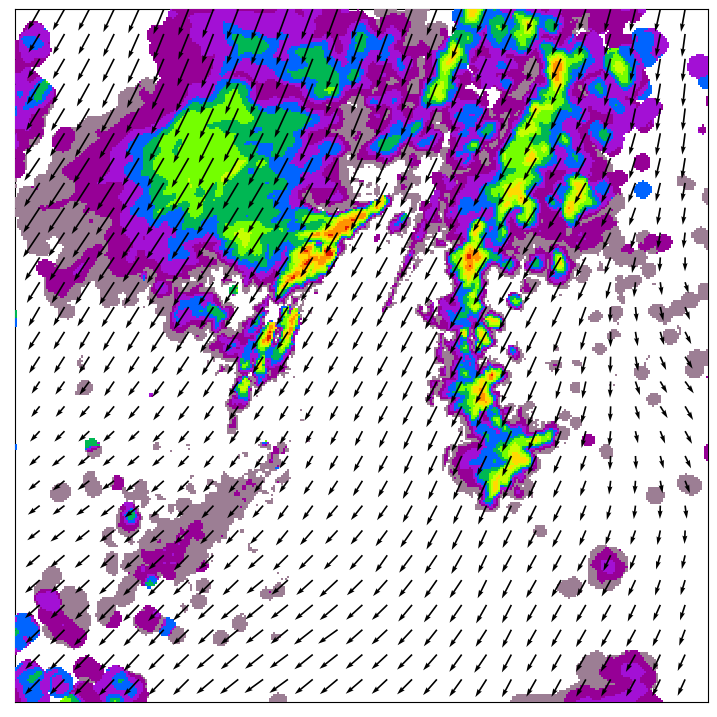

In [56]:
fig, ax = plt.subplots(figsize=(9, 9))
plot_precip_field(x_np[-1], colorbar=False, units='dBZ')
quiver(mf_lk, step=12, quiver_kwargs={'scale': 100})
plt.savefig('mf_lk.pdf',bbox_inches='tight')

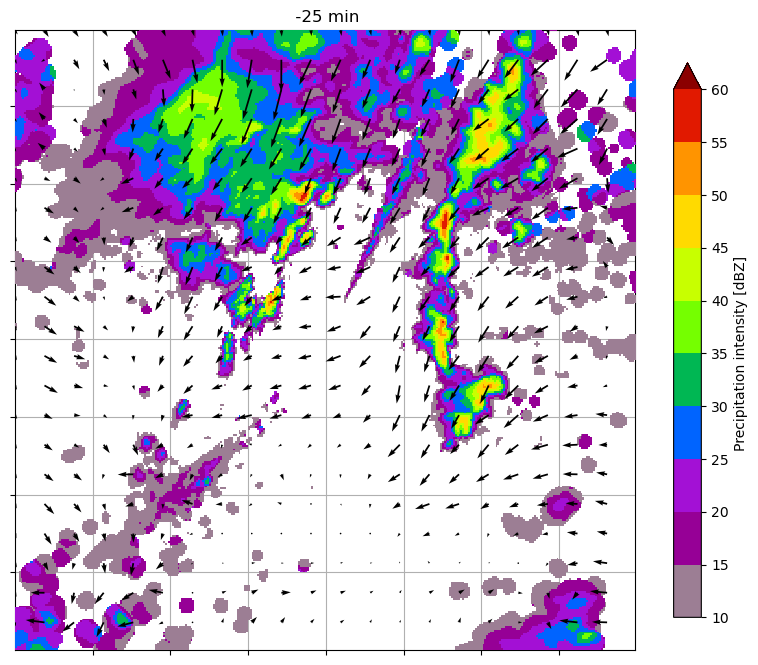

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
from pysteps.visualization import plot_precip_field, quiver

fig, ax = plt.subplots(figsize=(10, 9))

plot_precip_field(x_np[0], units='dBZ')

def update(frame):
    plt.cla()
    if frame >= 6:
        #plt.imshow(nowcast_np[0][frame-6], vmin=0, vmax=70, cmap='gist_ncar')
        plot_precip_field(nowcast_np[0][frame-6], colorbar=False, units='dBZ')
        quiver(mfcast_np[0][frame-6], step=16, quiver_kwargs={'scale': 100})
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        #plt.imshow(x_np[frame], vmin=0, vmax=70, cmap='gist_ncar')
        plot_precip_field(x_np[frame], colorbar=False, units='dBZ')
        quiver(mfcast_np[0][0], step=16, quiver_kwargs={'scale': 100})
        # plt.title(f"{(frame-5)*5:+4d} min")
    ax.xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    plt.title(f"{(frame-5)*5:+4d} min")

ani = animate.FuncAnimation(fig=fig, func=update, frames=12)
HTML(ani.to_jshtml())

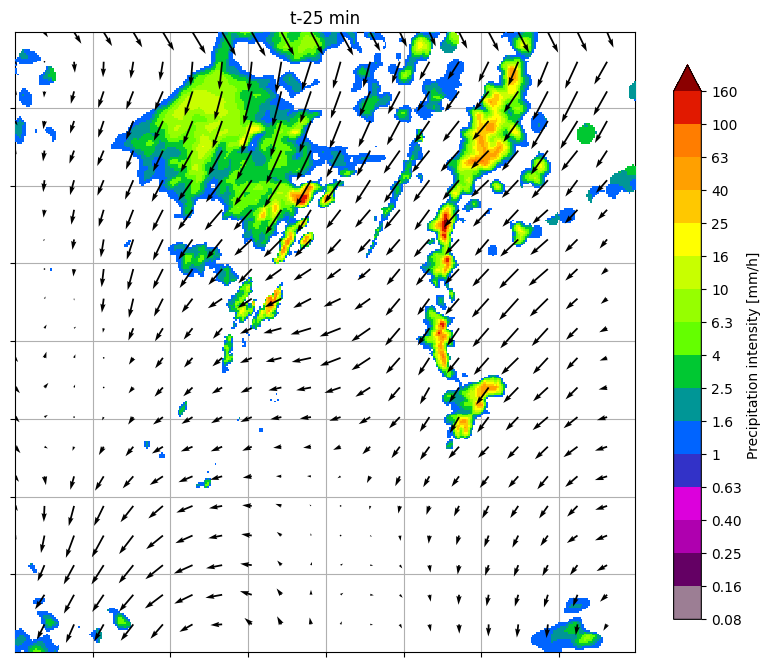

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
from pysteps.visualization import plot_precip_field, quiver

fig, ax = plt.subplots(figsize=(10, 9))

plot_precip_field(x_np_mmh[0])

def update(frame):
    plt.cla()
    if frame >= 6:
        #plt.imshow(nowcast_np[0][frame-6], vmin=0, vmax=70, cmap='gist_ncar')
        plot_precip_field(nowcast_np_mmh[0][frame-6], colorbar=False)
        quiver(mfcast_np[0][frame-6], step=16, quiver_kwargs={'scale': 100})
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        #plt.imshow(x_np[frame], vmin=0, vmax=70, cmap='gist_ncar')
        plot_precip_field(x_np_mmh[frame], colorbar=False)
        quiver(mfcast_np[0][0], step=16, quiver_kwargs={'scale': 100})
        # plt.title(f"{(frame-5)*5:+4d} min")
    ax.xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    plt.title(f"t{(frame-5)*5:+2d} min")

ani = animate.FuncAnimation(fig=fig, func=update, frames=12)
ani.save('LUPIN_motion_fields.gif', fps=2)
HTML(ani.to_jshtml())

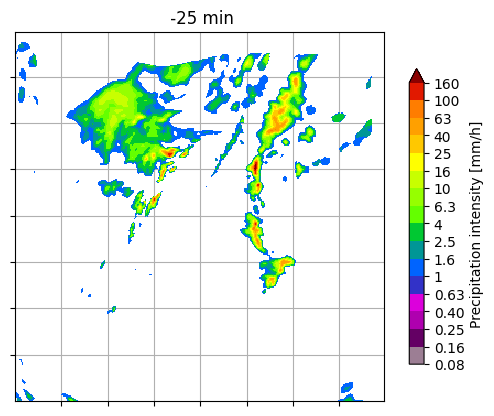

In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
from pysteps.visualization import plot_precip_field

fig, ax = plt.subplots()

plot_precip_field(x_lagrangian_np_mmh[0])

def update(frame):
    plt.cla()
    if frame >= 6:
        plot_precip_field(nowcast_np_mmh[0][frame-6], colorbar=False)
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        plot_precip_field(x_lagrangian_np_mmh[frame], colorbar=False)
        # plt.title(f"{(frame-5)*5:+4d} min")
    #plt.axis('off')
    plt.title(f"{(frame-5)*5:+4d} min")
    ax.xaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.yaxis.set_ticks(np.array([1, 2, 3, 4, 5, 6, 7]) * 42)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)

ani = animate.FuncAnimation(fig=fig, func=update, frames=6)
ani.save('LUPIN_lagrangian_mapping.gif', fps=2)
HTML(ani.to_jshtml()) 

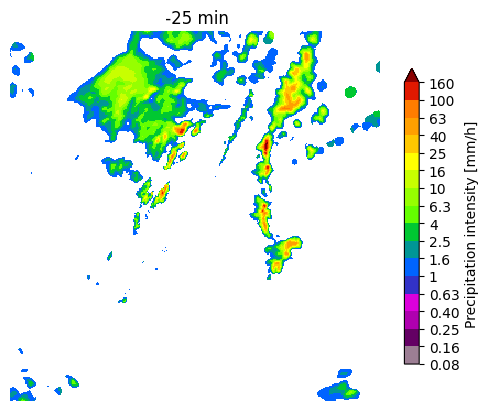

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML
from pysteps.visualization import plot_precip_field

fig, ax = plt.subplots()

plot_precip_field(x_np_mmh[0])

def update(frame):
    plt.cla()
    if frame >= 6:
        plot_precip_field(nowcast_np_mmh[0][frame-6], colorbar=False)
        # plt.title(f"{(frame-5)*5:+4d} min")
    else:
        plot_precip_field(x_np_mmh[frame], colorbar=False)
        # plt.title(f"{(frame-5)*5:+4d} min")
    plt.axis('off')
    plt.title(f"{(frame-5)*5:+4d} min")

ani = animate.FuncAnimation(fig=fig, func=update, frames=6)
ani.save('LUPIN_input.gif', fps=2)
HTML(ani.to_jshtml()) 

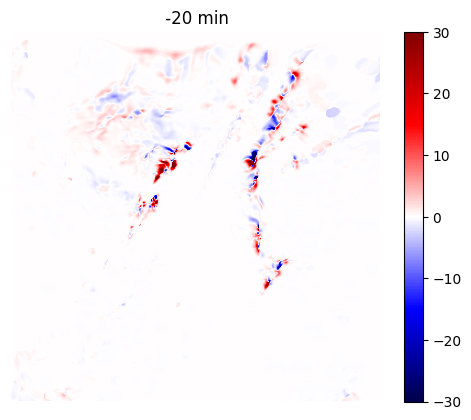

In [33]:
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML

fig, ax = plt.subplots()

plt.imshow(pred_np[0][0], cmap='seismic', vmin=-30, vmax=30)
cbar = plt.colorbar()

# x_lagrangian_diff_np[x_lagrangian_diff_np == 0] = np.nan
# y_i_np[y_i_np <= 0] = np.nan

def update(frame):
    plt.cla()
    if frame == 5:
        plt.imshow(pred_np[0][0], cmap='seismic', vmin=cbar.vmin, vmax=cbar.vmax)
    else:
        plt.imshow(x_lagrangian_diff_np[frame], cmap='seismic', vmin=cbar.vmin, vmax=cbar.vmax)
    plt.axis('off')
    plt.title(f"{(frame-4)*5:+4d} min")
    # plt.show()

ani = animate.FuncAnimation(fig=fig, func=update, frames=5)
ani.save('LUPIN_time_differenced_inputs.gif', fps=2)
HTML(ani.to_jshtml())

(-0.5, 335.5, 335.5, -0.5)

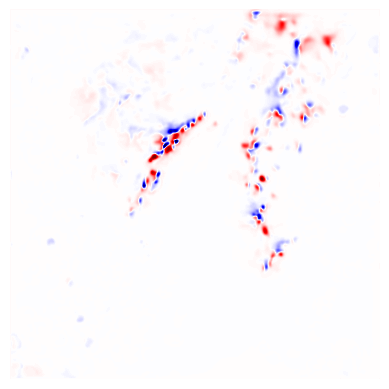

In [20]:
plt.imshow(pred_np[0][0], cmap='seismic', vmin=cbar.vmin, vmax=cbar.vmax)
plt.axis('off')

<Axes: >

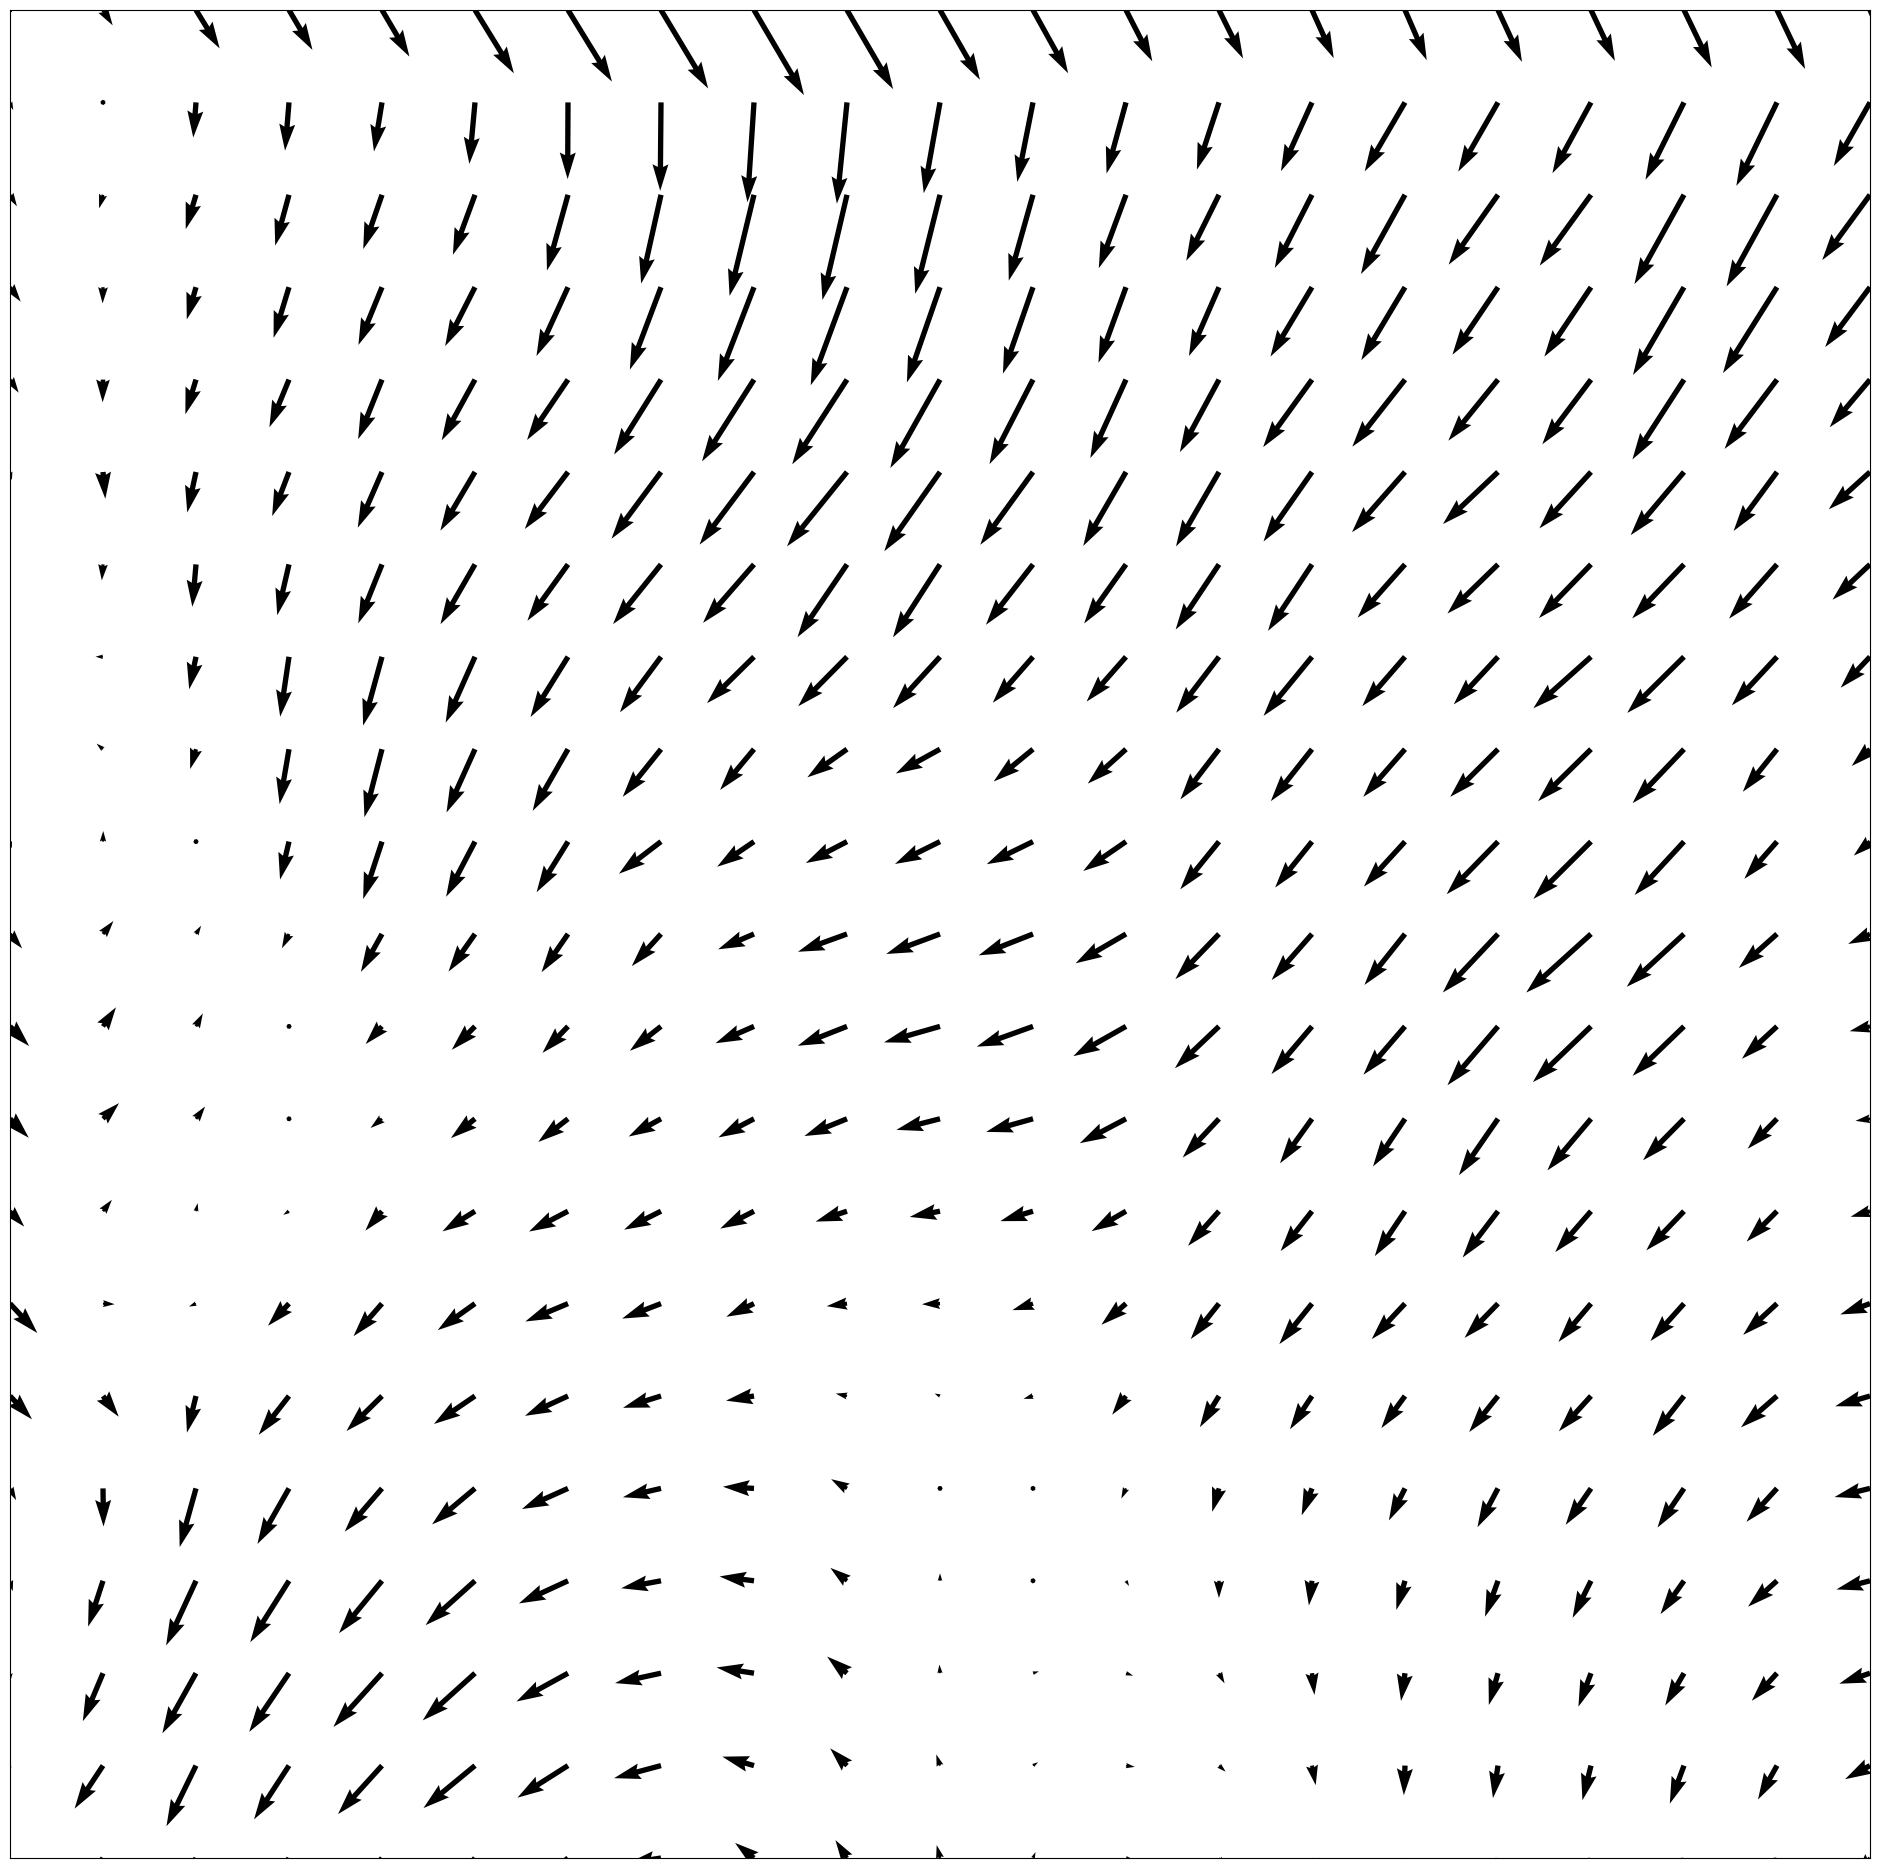

In [16]:
from pysteps.visualization import plot_precip_field, quiver
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

fig, ax = plt.subplots(figsize=(24, 24))
# plt.imshow(x_np[-1], cmap='gist_ncar')
#plot_precip_field(pred_total_np[0][0], ax=ax, axis="off", units="dBZ")
mf_np = mf[0].detach().cpu().numpy()
#mf_np[mf_np > 0.1] = 0.1
#mf_np[mf_np < -0.1] = -0.1
# mf_np[1] *= -1

# Plot the motion field vectors
quiver(mf_np, step=16, quiver_kwargs={'scale': 100})